# Chapter 5 - Connecting Causality and Deep Learning

The notebook is a code companion to chapter 5 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/).

<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%205/chapter_5_Connecting_Causality_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was written in Google Colab using Python version 3.10.12. The versions of the main libraries include:
* pyro version 1.84
* torch version 2.2.1
* pandas version 2.0.3
* torchvision vserions 0.18.0+cu121




Pgmpy allows us to fit conventional Bayesian networks on a causal DAG. However, with modern deep probabilistic machine learning frameworks like pyro, we can build more nuanced and powerful causal models.  In this tutorial, we fit a variational autoencoder on a causal DAG that represents a dataset that mixes handwritten MNIST digits and typed T-MNIST images.

![TMNIST-MNIST](https://github.com/altdeep/causalML/blob/master/book/chapter%205/images/MNIST-TMNIST.png?raw=1)

In [1]:
!pip install pyro-ppl==1.8.4
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 15.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

## Listing 5.1: Setup for GPU training

The code will run faster if we use CUDA, if it's available.

In [2]:
import torch    #A
USE_CUDA = False    #A
DEVICE_TYPE = torch.device("cuda" if USE_CUDA else "cpu")    #A
#A Use CUDA if it is available.

## Listing 5.2: Combining the data

First, we create a Dataset object that will combine our two datasets.

In [3]:
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
from torchvision import transforms

class CombinedDataset(Dataset):    #A
    def __init__(self, csv_file):
        self.dataset = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        images = self.dataset.iloc[idx, 3:]    #B
        images = np.array(images, dtype='float32')/255.  #B
        images = images.reshape(28, 28)    #B
        transform = transforms.ToTensor()    #B
        images = transform(images)    #B
        digits = self.dataset.iloc[idx, 2]    #C
        digits = np.array([digits], dtype='int')    #C
        is_handwritten = self.dataset.iloc[idx, 1]    #D
        is_handwritten = np.array([is_handwritten], dtype='float32')    #D
        return images, digits, is_handwritten    #E

#A This class loads and processes a dataset that combines the MNIST and Typeface MNIST. The output is a torch.utils.data.Dataset object.
#B Load, normalize, and reshape the images to a 28x28 pixel.
#C Get and process the digits labels, 0-9.
#D 1 for handwritten digits (MNIST) 0 for “typed’ digits (TMNIST).
#E Return tuple of the image, the digit label, and the is_handwritten label.

## Listing 5.3: Downloading, splitting and loading the data

Next, we'll download the data and create the combined dataset.

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

def setup_dataloaders(batch_size=64, use_cuda=USE_CUDA):    #A
    combined_dataset = CombinedDataset(
"https://raw.githubusercontent.com/altdeep/causalML/master/datasets/combined_mnist_tmnist_data.csv"
    )
    n = len(combined_dataset)    #B
    train_size = int(0.8 * n)    #B
    test_size = n - train_size    #B
    train_dataset, test_dataset = random_split(    #B
        combined_dataset,    #B
        [train_size, test_size],    #B
        generator=torch.Generator().manual_seed(42)    #B
    )    #B
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = DataLoader(    #C
        train_dataset,    #C
        batch_size=batch_size,    #C
        shuffle=True,    #C
        **kwargs    #C
    )    #C
    test_loader = DataLoader(    #C
        test_dataset,    #C
        batch_size=batch_size,    #C
        shuffle=True,    #C
        **kwargs    #C
    )    #C
    return train_loader, test_loader
#A Setup data loader that loads the data and splits it into training and test sets
#B Allot 80% of the data to training data, the remaining 20% to test data.
#C Create training and test loaders.

## Listing 5.4: Implement the decoder

First, we specify a decoder. The decoder maps the latent variable Z, a variable representing the value of the digit, and a binary variable representing whether the digit is handwritten.

In [5]:
from torch import nn

class Decoder(nn.Module):    #A
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        img_dim = 28 * 28    #B
        digit_dim = 10    #C
        is_handwritten_dim = 1    #D
        self.softplus = nn.Softplus()    #E
        self.sigmoid = nn.Sigmoid()    #E
        encoding_dim = z_dim + digit_dim + is_handwritten_dim    #F
        self.fc1 = nn.Linear(encoding_dim, hidden_dim)    #F
        self.fc2 = nn.Linear(hidden_dim, img_dim)    #G

    def forward(self, z, digit, is_handwritten):    #H
        input = torch.cat([z, digit, is_handwritten], dim=1)   #I
        hidden = self.softplus(self.fc1(input))    #J
        img_param = self.sigmoid(self.fc2(hidden))    #K
        return img_param
#A The decoder method of a VAE class.
#B Image is 28 by 28 pixels
#C Digit is one-hot encoded digits 0-9, i.e., a vector of length 10.
#D An indicator for if the digit is handwritten that has size 1
#E The softplus and sigmoid are nonlinear transforms (activation functions) used in mapping between layers.
#F fc1 is a linear function that maps Z vector, the digit, and the is_handwritten to a linear out, which is passed through a softplus activation function to create a "hidden layer" - a vector whose length is given by hidden_layer.
#G The fc2 linearly maps the hidden layer to an output passed to a sigmoid function. The resulting value is a value between 0 and 1.
#H Define the forward computation from the latent Z variable value to a generated X variable value.
#I First combine Z and the labels.
#J Then compute the hidden layer.
#K Finally, pass the hidden layer to a linear transform, then to a sigmoid transform to output a parameter vector of length 784. Each element of the vector corresponds to a Bernoulli parameter value for an image pixel.


## Listing 5.5: The causal model

The `model` method implements the causal model. First it samples the latent variable Z, the digit variable, and the is_handwritten variable. These are passed to the decoder, which generates the image.

In [6]:
import pyro
import pyro.distributions as dist

dist.enable_validation(False)    #A
def model(self, data_size=1):    #B
    pyro.module("decoder", self.decoder)    #B
    options = dict(dtype=torch.float32, device=DEVICE_TYPE)
    z_loc = torch.zeros(data_size, self.z_dim, **options)    #C
    z_scale = torch.ones(data_size, self.z_dim, **options)    #C
    z = pyro.sample("Z", dist.Normal(z_loc, z_scale).to_event(1))    #C
    p_digit = torch.ones(data_size, 10, **options)/10    #D
    digit = pyro.sample(    #D
        "digit",    #D
        dist.OneHotCategorical(p_digit)    #D
    )    #D
    p_is_handwritten = torch.ones(data_size, 1, **options)/2    #E
    is_handwritten = pyro.sample(    #E
        "is_handwritten",    #E
        dist.Bernoulli(p_is_handwritten).to_event(1)    #E
    )    #E
    img_param = self.decoder(z, digit, is_handwritten)    #F
    img = pyro.sample("img", dist.Bernoulli(img_param).to_event(1))  #G
    return img, digit, is_handwritten
#A Disabling distribution validation lets Pyro calculate loglikelihoods for pixels even though the pixels are not binary values.
#B The model of a single image. Within the method we register the decoder, a PyTorch module, with Pyro. This lets Pyro know about the parameters inside of the decoder network.
#C We model the joint probability of Z, digit, and is_handwritten sampling each from canonical distributions. We sample Z from a multivariate normal with location parameter z_loc (all zeros) and scale parameter z_scale (all ones).
#D We also sample the digit from a one-hot categorical distribution. Equal probability is assigned to each digit.
#E We similarly sample the is_handwritten variable from a Bernoulli.
#F The decoder maps digit, is_handwritten, and Z to a probability parameter vector.
#G That parameter vector is passed to the Bernoulli distribution, which models the pixel values in the data. The pixels are not technically Bernoulli binary variables, but we'll relax this assumption.

## Listing 5.6 Method for applying model to N images in data

`training_model` extends `model` towards representing each image in the dataset.

In [7]:
def training_model(self, img, digit, is_handwritten, batch_size):    #A
    conditioned_on_data = pyro.condition(    #B
        self.model,
        data={
            "digit": digit,
            "is_handwritten": is_handwritten,
            "img": img
        }
    )
    with pyro.plate("data", batch_size):    #C
        img, digit, is_handwritten = conditioned_on_data(batch_size)
    return img, digit, is_handwritten
#A The model represents the data generating process for one image. The training_model applies that model to the N images in the training data.
#B Now we condition the model on the evidence in the training data.
#C This context manager represents the N-size plate representing repeating IID examples in the data in Figure 5.9. In this case, N is the batch size. It works like a for loop iterating over each data unit in the batch.

## Listing 5.7: Implement the encoder

The encoder takes an image, the digit, and whether the variable is handwritten, and infers the latent representation Z.

In [8]:
class Encoder(nn.Module):    #A
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        img_dim = 28 * 28    #B
        digit_dim = 10    #C
        is_handwritten_dim = 1
        self.softplus = nn.Softplus()    #D
        input_dim = img_dim + digit_dim + is_handwritten_dim    #E
        self.fc1 = nn.Linear(input_dim, hidden_dim)    #E
        self.fc21 = nn.Linear(hidden_dim, z_dim)    #F
        self.fc22 = nn.Linear(hidden_dim, z_dim)    #F

    def forward(self, img, digit, is_handwritten):    #G
        input = torch.cat([img, digit, is_handwritten], dim=1)    #H
        hidden = self.softplus(self.fc1(input))    #I
        z_loc = self.fc21(hidden)    #J
        z_scale = torch.exp(self.fc22(hidden))    #J
        return z_loc, z_scale
#A The encoder is an instance of a Pytorch module.
#B The input image is 28X28 = 784 pixels.
#C The digit dimension is 10.
#D In the encoder, we’ll only use the softplus transform (activation function).
#E The linear transform fc1 combines with the softplus to map the 784 dimensional pixel vector, 10 dimensional digit label vector, and 2 dimensional is_handwritten vector to the hidden layer.
#F The linear transforms fc21 and fc22 will combine with the softplus to map the hidden vector to Z’s vector space.
#G Define the reverse computation from an observed X variable value to a latent Z variable value.
#H Combine the image vector, digit label, and is-handwritten label into one input.
#I Map the input to the hidden layer.
#J The VAE framework will sample Z from a Normal distribution that approximates P(Z|img, digit, is_handwritten). The final transforms map the hidden layer to a location and scale parameter for that Normal distribution.

## Listing 5.8: The guide function

`training_guide` contains the encoder. The purpose of `training_guide` is to approximate P(Z|image, digit, is_handwritten) during training.

In [9]:
def training_guide(self, img, digit, is_handwritten, batch_size):    #A
    pyro.module("encoder", self.encoder)    #B
    options = dict(dtype=torch.float32, device=DEVICE_TYPE)
    with pyro.plate("data", batch_size):    #C
        z_loc, z_scale = self.encoder(img, digit, is_handwritten)    #D
        normal_dist = dist.Normal(z_loc, z_scale).to_event(1)    #D
        z = pyro.sample("Z", normal_dist)    #E
#A training_guide is a method of the VAE which will use the encoder.
#B Register the encoder so Pyro is aware of its weight parameters.
#C This is the same plate context manager for iterating over the batch data that we see in the training_model.
#D Use the encoder to map an image and its labels to parameters of a Normal distribution.
#E Sample Z from that Normal distribution.

## Listing 5.9: The full VAE code

Now we implement all the parts in the VAE.

In [10]:
class VAE(nn.Module):
    def __init__(
        self,
        z_dim=50,    #A
        hidden_dim=400,    #B
        use_cuda=USE_CUDA,
    ):
        super().__init__()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.setup_networks()

    def setup_networks(self):    #C
        self.encoder = Encoder(self.z_dim, self.hidden_dim)
        self.decoder = Decoder(self.z_dim, self.hidden_dim)
        if self.use_cuda:
            self.cuda()

    model = model    #D
    training_model = training_model    #D
    training_guide = training_guide    #D

#A Setting the latent dimension to have a dimension of 50.
#B Setting the hidden layers to have a dimension of 400.
#C Setup the encoder and decoder.
#D Adding in the methods for model, training_model, and training_guide.

## Listing 5.10 Helper function for plotting images

The following utility functions helps us visualize progress during training.

In [11]:
def plot_image(img, title=None):    #A
    fig = plt.figure()
    plt.imshow(img.cpu(), cmap='Greys_r', interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.show()
#A Helper function for plotting an image

## Listing 5.11: Define a helper functions for reconstructing and viewing the images

These additional utility functions help us selected and reshape images, as well as generate new images.

In [12]:
import matplotlib.pyplot as plt

def reconstruct_img(vae, img, digit, is_hw, use_cuda=USE_CUDA):    #A
    img = img.reshape(-1, 28 * 28)
    digit = F.one_hot(torch.tensor(digit), 10)
    is_hw = torch.tensor(is_hw).unsqueeze(0)
    if use_cuda:
        img = img.cuda()
        digit = digit.cuda()
        is_hw = is_hw.cuda()
    z_loc, z_scale = vae.encoder(img, digit, is_hw)
    z = dist.Normal(z_loc, z_scale).sample()
    img_expectation = vae.decoder(z, digit, is_hw)
    return img_expectation.squeeze().view(28, 28).detach()

def compare_images(img1, img2):    #B
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(img1.cpu(), cmap='Greys_r', interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(img2.cpu(), cmap='Greys_r', interpolation='nearest')
    plt.axis('off')
    plt.title('reconstruction')
    plt.show()
#A Given an input image, "reconstructs" the image by passing through the encoder then through the decoder.
#B Plots two images side by side for comparison.

## Listing 5.12: Data processing helper functions for training

Next, we'll create some helper functions for handling the data. We'll use `get_random_example` to grab random images from the dataset. `reshape_data` will convert an image and its labels into input for the encoder. We'll use `generate_data` and `generate_coded_data` will simulate an image from the model.

In [13]:
import torch.nn.functional as F

def get_random_example(loader):    #A
    random_idx = np.random.randint(0, len(loader.dataset))    #A
    img, digit, is_handwritten = loader.dataset[random_idx]    #A
    return img.squeeze(), digit, is_handwritten    #A

def reshape_data(img, digit, is_handwritten):    #B
    digit = F.one_hot(digit, 10).squeeze()    #B
    img = img.reshape(-1, 28*28)    #B
    return img, digit, is_handwritten    #B

def generate_coded_data(vae, use_cuda=USE_CUDA):    #C
    z_loc = torch.zeros(1, vae.z_dim)    #C
    z_scale = torch.ones(1, vae.z_dim)    #C
    z = dist.Normal(z_loc, z_scale).to_event(1).sample()    #C
    p_digit = torch.ones(1, 10)/10    #C
    digit = dist.OneHotCategorical(p_digit).sample()    #C
    p_is_handwritten = torch.ones(1, 1)/2    #C
    is_handwritten = dist.Bernoulli(p_is_handwritten).sample()    #C
    if use_cuda:    #C
        z = z.cuda()
        digit = digit.cuda()
        is_handwritten = is_handwritten.cuda()    #C
    img = vae.decoder(z, digit, is_handwritten)    #C
    return img, digit, is_handwritten    #C

def generate_data(vae, use_cuda=USE_CUDA):    #D
    img, digit, is_handwritten = generate_coded_data(vae, use_cuda)    #D
    img = img.squeeze().view(28, 28).detach()    #D
    digit = torch.argmax(digit, 1)    #D
    is_handwritten = torch.argmax(is_handwritten, 1)    #D
    return img, digit, is_handwritten    #D
#A Chose a random example from the dataset.
#B Reshape the data.
#C Generate data that is encoded.
#D Generate (unencoded) data.

## Listing 5.13: Set up the training procedure

Next we set up traing. The training objective `Trace_ELBO` simultaneously trains the parameters of the encoder and the decoder. It focuses on minimizing reconstruction error (how much information is lost when an image encoded, and then decoded once again) and [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the distribution modeled by the guide (the variational distribution) and the P(Z|image, is_handwritten, digit).

In [14]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.clear_param_store()    #A
vae = VAE()    #B
train_loader, test_loader = setup_dataloaders(batch_size=256)    #C
svi_adam = Adam({"lr": 1.0e-3})    #D
model = vae.training_model    #E
guide = vae.training_guide    #E
svi = SVI(model, guide, svi_adam, loss=Trace_ELBO())    #E
#A Clear any values of the parameters in the guide memory.
#B Initalize the VAE
#C Load the data
#D Initialize the optizer
#E Initialize the SVI loss calculator. Loss negative "expected lower bound" (ELBO).

## Listing 5.14: Setting up a test evaluation procedure

When training generative models, it is useful to setup a procedure that uses test data to evaluate how well training is progressing. You can include anything you think is useful to monitor during training. Here, I calculate and print the loss function on the test data, just to make sure test loss is progressively decreasing along with training loss (a flattening of test loss while training loss continued to decrease would indicate overfitting).

But a more direct signal at how well our model is training is to generate and view images. In my test evaluation procedure, I produce two visualizations. First, I inspect how well it can reconstruct a random image from the test data. I pass the image through the encoder then through the decoder, creating a “reconstruction” of the image. Then I plot the original and reconstructed image side-by-side and compare them visually, looking to see that they are close to identical.

Next, I visualize how well it is performing as an overall generative model by generating and plotting an image from scratch. I run this code once each time a certain number of epochs are run.

In [15]:
def test_epoch(vae, test_loader):
    epoch_loss_test = 0    #A
    for img, digit, is_hw in test_loader:    #A
        batch_size = img.shape[0]    #A
        if USE_CUDA:    #A
            img = img.cuda()    #A
            digit = digit.cuda()    #A
            is_hw = is_hw.cuda()    #A
        img, digit, is_hw = reshape_data(    #A
            img, digit, is_hw    #A
        )    #A
        epoch_loss_test += svi.evaluate_loss(    #A
            img, digit, is_hw, batch_size    #A
        )    #A
    test_size = len(test_loader.dataset)    #A
    avg_loss = epoch_loss_test/test_size    #A
    print("Epoch: {} avg. test loss: {}".format(epoch, avg_loss))    #A
    print("Comparing a random test image to its reconstruction:")    #B
    random_example = get_random_example(test_loader)    #B
    img_r, digit_r, is_hw_r = random_example    #B
    img_recon = reconstruct_img(vae, img_r, digit_r, is_hw_r)    #B
    compare_images(img_r, img_recon)    #B
    print("Generate a random image from the model:")    #C
    img_gen, digit_gen, is_hw_gen = generate_data(vae)    #C
    plot_image(img_gen, "Generated Image")    #C
    print("Intended digit: ", int(digit_gen))    #C
    print("Intended as handwritten: ", bool(is_hw_gen == 1))    #C
#A Calculate and print test loss.
#B Compare a random test image to its reconstruction.
#C Generate a random image from the model.

## Listing 5.15: Running training and plotting progress

Finally, we run training.

Epoch: 0 avgs training loss: 4019819.203689575
Epoch: 0 avg. test loss: 101.84467435913086
Comparing a random test image to its reconstruction:


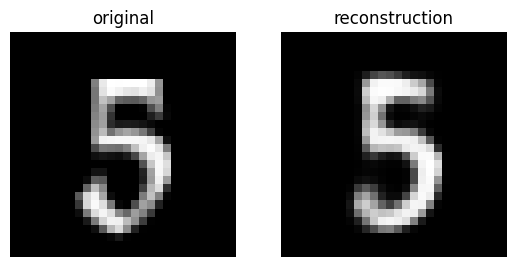

Generate a random image from the model:


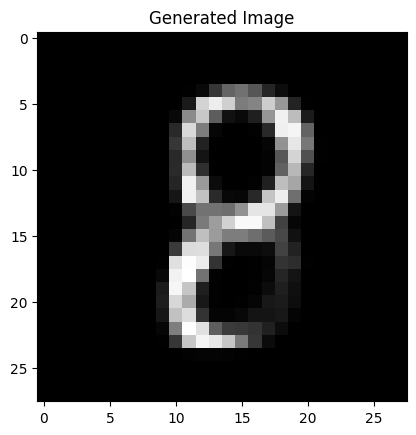

Intended digit:  8
Intended as handwritten:  False
Epoch: 1 avgs training loss: 4015543.9763946533
Epoch: 2 avgs training loss: 4014806.234451294
Epoch: 3 avgs training loss: 4011313.3448028564
Epoch: 4 avgs training loss: 4010832.078201294
Epoch: 5 avgs training loss: 4006672.9878692627
Epoch: 6 avgs training loss: 4006353.435623169
Epoch: 7 avgs training loss: 4004289.1900177
Epoch: 8 avgs training loss: 4001874.8618927
Epoch: 9 avgs training loss: 3999677.706375122
Epoch: 10 avgs training loss: 3997699.288406372
Epoch: 10 avg. test loss: 101.34089661865234
Comparing a random test image to its reconstruction:


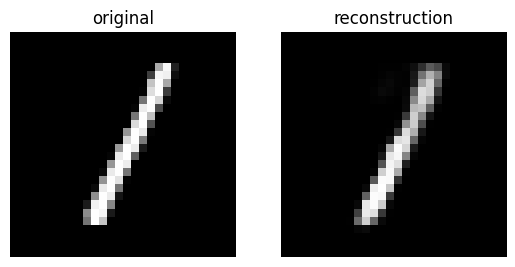

Generate a random image from the model:


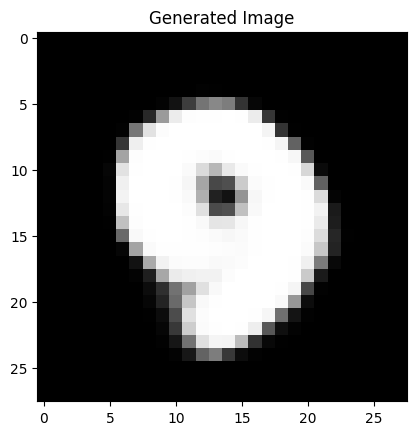

Intended digit:  9
Intended as handwritten:  False
Epoch: 11 avgs training loss: 3994829.5928497314
Epoch: 12 avgs training loss: 3993153.805252075
Epoch: 13 avgs training loss: 3992091.893875122
Epoch: 14 avgs training loss: 3991439.182449341
Epoch: 15 avgs training loss: 3988107.4261016846
Epoch: 16 avgs training loss: 3987029.8050079346
Epoch: 17 avgs training loss: 3984113.448074341
Epoch: 18 avgs training loss: 3983580.325515747
Epoch: 19 avgs training loss: 3980452.5916290283
Epoch: 20 avgs training loss: 3978874.7400665283
Epoch: 20 avg. test loss: 101.21306309204101
Comparing a random test image to its reconstruction:


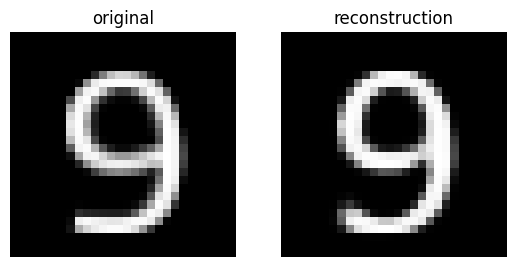

Generate a random image from the model:


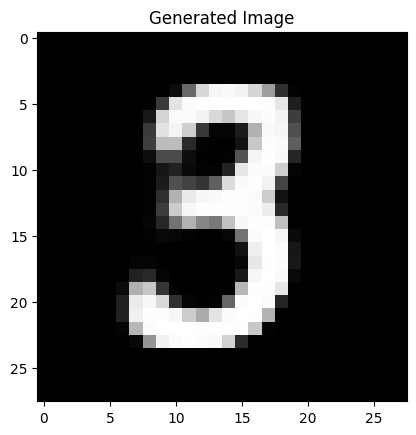

Intended digit:  3
Intended as handwritten:  False
Epoch: 21 avgs training loss: 3978292.0882110596
Epoch: 22 avgs training loss: 3976708.4449005127
Epoch: 23 avgs training loss: 3974769.9781036377
Epoch: 24 avgs training loss: 3973768.586502075
Epoch: 25 avgs training loss: 3973018.3150177
Epoch: 26 avgs training loss: 3969929.781814575
Epoch: 27 avgs training loss: 3968498.0952911377
Epoch: 28 avgs training loss: 3967000.5493927
Epoch: 29 avgs training loss: 3965123.9717559814
Epoch: 30 avgs training loss: 3965020.067214966
Epoch: 30 avg. test loss: 100.91861611938477
Comparing a random test image to its reconstruction:


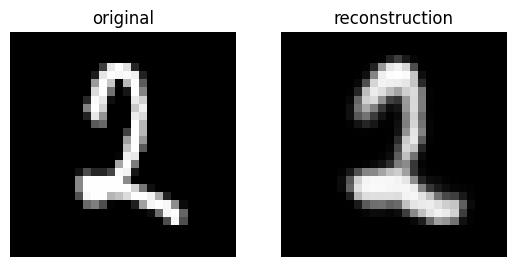

Generate a random image from the model:


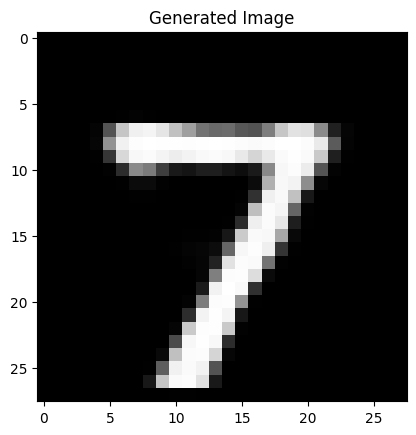

Intended digit:  7
Intended as handwritten:  False
Epoch: 31 avgs training loss: 3963955.542312622


In [17]:
NUM_EPOCHS = 2500
TEST_FREQUENCY = 10

train_loss = []
train_size = len(train_loader.dataset)

for epoch in range(0, NUM_EPOCHS+1):    #A
    loss = 0
    for img, digit, is_handwritten in train_loader:
        batch_size = img.shape[0]
        if USE_CUDA:
            img = img.cuda()
            digit = digit.cuda()
            is_handwritten = is_handwritten.cuda()
        img, digit, is_handwritten = reshape_data(
            img, digit, is_handwritten
        )
        loss += svi.step(    #B
            img, digit, is_handwritten, batch_size    #B
        )    #B
    avg_loss = loss / train_size
    print("Epoch: {} avgs training loss: {}".format(epoch, loss))
    train_loss.append(avg_loss)
    if epoch % TEST_FREQUENCY == 0:    #C
        test_epoch(vae, test_loader)    #C
#A Run the training procedure for a certain number of epochs.
#B Run a training step on one batch in one epoch.
#C The test data evaluation procedure runs every 10 epochs.

We can continue to use `generate_data` to generate from the model once we've trained it. Finally, we can save the resulting model.

In [ ]:
#torch.save(vae.state_dict(), 'mnist_tmnist_weights.pt')